This is a simple demonstration of image processing using dask arrays with [ghost cells](http://dask.readthedocs.org/en/latest/ghost.html).

We apply the Canny edge detection algorithm to our image. Which is suitable for ghosted arrays because it is relatively "local", that is each pixel depends on pixel only a small fixed distance away.

The algorithm applies a Gaussian filter to the image and then takes the 2D gradient. Points where the gradient is larger than some threshold are "edges". 

In [1]:
from os.path import getsize
from PIL import Image

import matplotlib
from matplotlib import pyplot as plt

import numpy as np
from skimage.feature import blob_doh, canny
from skimage.color import rgb2gray

import dask.array as da

In [2]:
# printing
%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

If we assume the file is too large to load into memory, how would I load it?

In [3]:
file_name = 'hudf.jpg' # hubble ultra deep field
pil_img = Image.open(file_name) # ~ 61MB
getsize(file_name) * 1e-6


63.87609

In [4]:
color_img = np.asarray(pil_img)
color_img.shape, color_img.nbytes * 1e-6 # still in memory here

((6200, 6200, 3), 115.32)

In [5]:
# convert to greyscale
img = rgb2gray(color_img)  # this reshapes the array, so it is 2D now.
img.shape

(6200, 6200)

So we have the image in a numpy array. How does it look?

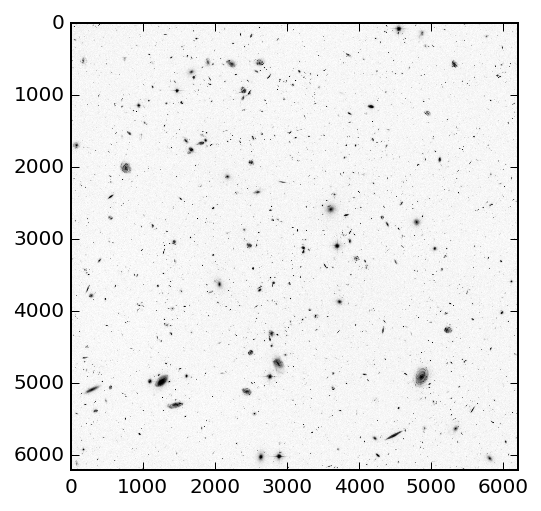

In [6]:
plt.imshow(img, cmap='Greys')

Lets run an edge detection algorithm on the numpy array.

In [7]:
# took these numbers from another example
%time np_edges = canny(img, sigma=1) 

CPU times: user 12.8 s, sys: 2.74 s, total: 15.5 s
Wall time: 15.5 s


This used all my memory and a bunch of swap. Bad.

So lets try this with a dask array.

In [8]:
arr = da.from_array(img, chunks=(1000, 1000))
arr.nbytes * 1e-6

307.51999999999998

In [9]:
# make the ghosted array
padding = {0: 50, 1:50}
ghost_array = da.ghost.ghost(arr, depth={0: 50, 1: 50}, boundary={0: 'periodic', 1: 'periodic'})
ghost_array.nbytes * 1e-6

380.88

I don't actually know the radius in pixels that this effects. But the radius needs to be smaller than the padding.

In [10]:
def func(block):
    return canny(block, sigma=1)

It would be nice if I could call `ghost_array.trim()` to trim an ghost array.

In [11]:
filtered = ghost_array.map_blocks(func)
trimmed = da.ghost.trim_internal(filtered, padding)
trimmed.shape # check that were back to normal shape

(6200, 6200)

In [12]:
%time darr = np.array(trimmed)

CPU times: user 24.2 s, sys: 1.12 s, total: 25.3 s
Wall time: 6.63 s


That used around %45 of memory

I'll zoom in on an interesting section here

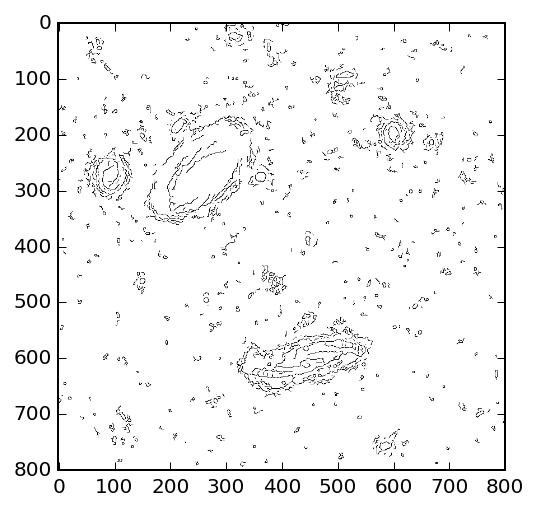

In [13]:
slice_ = slice(4700,5500), slice(1000, 1800)
plt.imshow(darr[slice_], cmap='Greys')

Here is an ovelay with the original image, so you can see what we detected.

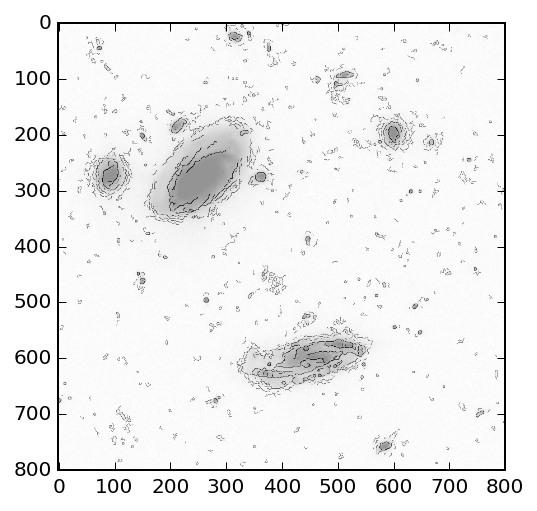

In [14]:
plt.imshow(darr[slice_] + img[slice_], cmap='Greys')